In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud
import numpy as np

In [7]:
def generate_wordclouds(
    df, cluster_column, text_column, stop_words, max_words=100, top_n=10
):
    """
    Generates word clouds and displays them side-by-side in a grid layout with cluster stats in titles.
    
    Parameters:
    - df: DataFrame containing text and cluster labels.
    - cluster_column: Column with cluster labels.
    - text_column: Column with text to analyze.
    - tfidf_matrix: Optional precomputed TF-IDF matrix.
    - vectorizer: Pre-fitted vectorizer associated with the TF-IDF matrix.
    - max_words: Max words in word cloud.
    - top_n: Number of top terms to display.

    Returns:
    - None
    """
    
    # Create TF-IDF matrix
    vectorizer = TfidfVectorizer(max_features=10000, stop_words=stop_words)
    tfidf_matrix = vectorizer.fit_transform(df[text_column])
    
    feature_names = vectorizer.get_feature_names_out()
    
    # Identify unique clusters
    clusters = df[cluster_column].unique()
    n_clusters = len(clusters)
    
    # Create subplots (grid with 2 columns)
    cols = 2
    rows = (n_clusters + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
    axes = axes.flatten()
    
    for i, cluster in enumerate(clusters):
        cluster_indices = df[cluster_column] == cluster
        
        # Compute average sentiment, LIX, and upvotes
        avg_sentiment = df.loc[cluster_indices, "sentiment_score"].mean()
        avg_lix = df.loc[cluster_indices, "lix_score"].mean()
        avg_upvotes = df.loc[cluster_indices, "upvotes"].mean()
        
        # Format cluster statistics for the title
        stats_title = (
            f"Cluster {cluster}\n"
            f"Sentiment: {avg_sentiment:.2f}, LIX: {avg_lix:.2f}, Upvotes: {avg_upvotes:.1f}"
        )
        
        # Generate TF-IDF scores
        tfidf_scores = tfidf_matrix[cluster_indices].sum(axis=0).A1
        tfidf_dict = dict(zip(feature_names, tfidf_scores))
        
        # Display top terms
        top_terms = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
        print(f"\nCluster {cluster}: Top {top_n} Terms\n" + ", ".join(f"{term} ({score:.2f})" for term, score in top_terms))
        
        # Generate word cloud
        wordcloud = WordCloud(
            width=600, height=400, background_color="black", colormap="viridis", max_words=max_words
        ).generate_from_frequencies(tfidf_dict)
        
        # Plot on the appropriate subplot
        ax = axes[i]
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.axis("off")
        ax.set_title(stats_title, fontsize=12, color="black")
    
    # Hide any unused subplot axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    
    # Adjust layout for better spacing
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    plt.tight_layout()
    plt.show()


def plot_cluster_counts(df, cluster_column):
    """
    Plots the number of comments in each cluster.
    
    Parameters:
    - df: DataFrame containing the data.
    - cluster_column: Column with cluster labels.
    
    Returns:
    - None
    """
    # Count the number of comments in each cluster
    cluster_counts = df[cluster_column].value_counts().sort_index()

    # Plot the number of comments in each cluster
    plt.figure(figsize=(10, 6))
    cluster_counts.plot(kind='bar', color='skyblue')
    plt.title('Number of Comments in Each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Comments')
    plt.xticks(rotation=0)
    plt.show()

# Print examples from each cluster
def print_cluster_examples(df, cluster_column, text_column, n_examples=5):
    clusters = df[cluster_column].unique()
    for cluster in clusters:
        print(f"\nCluster {cluster} examples:")
        examples = df[df[cluster_column] == cluster][text_column].head(n_examples)
        for i, example in enumerate(examples, 1):
            print(f"{i}. {example}")
            # print the sentiment score of the example
            print(f"Sentiment score: {df[df[text_column] == example]['sentiment_score'].values[0]:.2f}")
        


# Plotting wordclouds for the clusters


Cluster 1: Top 10 Terms
people (19.08), jews (14.88), would (12.25), even (11.32), us (10.78), one (9.80), war (9.28), jewish (8.66), like (8.59), anti (8.55)

Cluster 3: Top 10 Terms
love (5.45), like (4.67), free (4.18), say (3.48), jews (3.44), good (3.26), stay (2.83), white (2.80), fuck (2.78), time (2.52)

Cluster 2: Top 10 Terms
like (19.43), people (17.45), would (12.67), support (12.09), love (11.21), good (10.75), jews (10.50), know (10.43), want (9.41), pro (9.37)

Cluster 4: Top 10 Terms
people (20.57), jews (14.95), war (14.72), would (12.45), want (11.48), like (9.65), us (9.51), anti (9.18), think (9.11), pro (8.98)

Cluster 0: Top 10 Terms
people (13.84), like (12.27), jews (10.96), would (10.84), one (10.52), pro (10.24), also (7.59), state (7.51), thank (7.48), country (7.37)


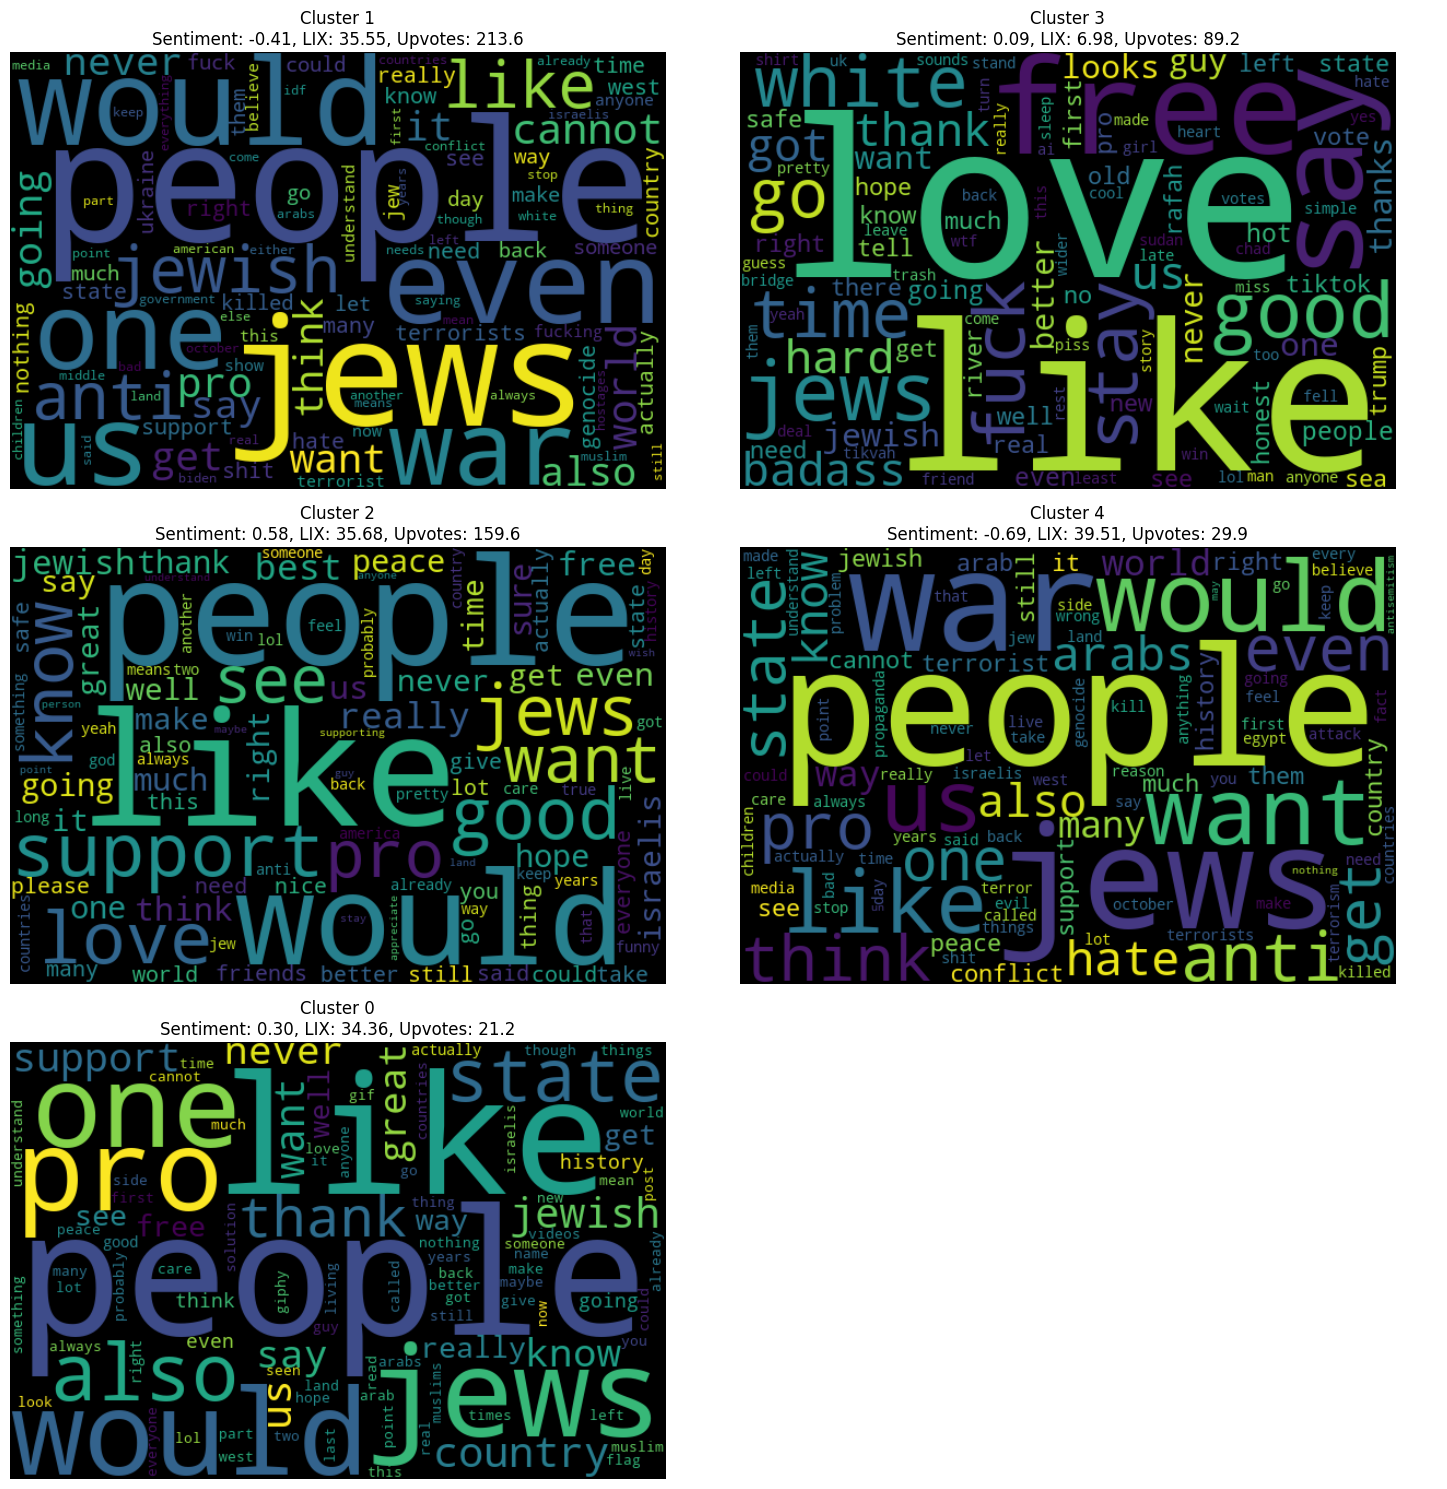

                sentiment_score  lix_score     upvotes
kmeans_cluster                                        
0                      0.304598  34.358307   21.222520
1                     -0.409953  35.545424  213.640321
2                      0.583497  35.684341  159.562074
3                      0.087499   6.982465   89.168675
4                     -0.689878  39.505300   29.870968


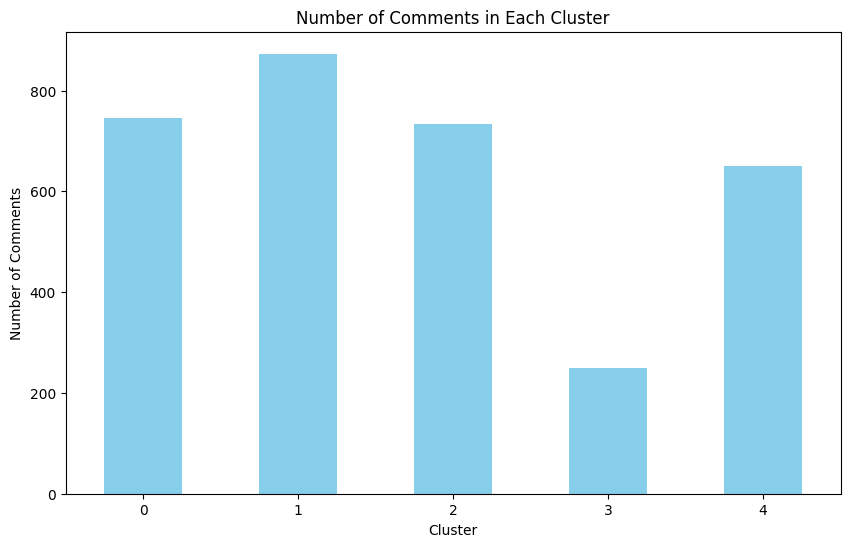

In [9]:
# Choose subreddit
subreddit = "Israel"

# Load the data
df = pd.read_csv(f"data/{subreddit}_clustered.csv")
df = df.dropna()

if subreddit == "baking":
    generate_wordclouds(
    df,
    cluster_column="kmeans_cluster",
    text_column="comment_no_stopwords",
    stop_words="english",
    max_words=100,
    top_n=10
    )
    
    cluster_stats = df.groupby('kmeans_cluster')[['sentiment_score', 'lix_score', 'upvotes']].mean()
    print(cluster_stats)

    plot_cluster_counts(df, "kmeans_cluster")


else:
    custom_stopwords = ["israel", "palestine", "hamas", "israeli", "palestinian", "iran", "palestinians", "gaza"]

    generate_wordclouds(
        df,
        cluster_column="kmeans_cluster",
        text_column="comment_no_stopwords",
        stop_words=custom_stopwords,
        max_words=100,
        top_n=10
    )

    cluster_stats = df.groupby('kmeans_cluster')[['sentiment_score', 'lix_score', 'upvotes']].mean()
    print(cluster_stats)

    plot_cluster_counts(df, "kmeans_cluster")
